# SAM2
import sam2 from huggingface.

## For image prediction:

```python
#文本提示 (Text prompts): 一段描述要分割区域的自然语言文本。例如：
input_prompts = "A red apple on a wooden table"

#点提示 (Point prompts): 指定图像中的某些像素点，以标记感兴趣的区域。点提示通常包括点的坐标和点的类型（正/负）。示例：
input_prompts={
    "points":[[100,200],[150,250],[150,250]],# 坐标点 (x, y)
    "labels":[1,0],# 1表示正样本，0表示负样本
}
#框提示 (Box prompts): 用矩形框标记目标区域。通常表示为左上角和右下角的坐标。例如：
input_prompts = {
    "boxes": [[50, 50, 200, 200]],  # 每个框的格式为 [x_min, y_min, x_max, y_max]
}
#混合提示 (Mixed prompts): 可以同时提供文本、点和框提示。例如：
input_prompts = {
    "text": "A cat sitting on a sofa",
    "points": [[120, 150], [200, 250]],
    "labels": [1, 1],
    "boxes": [[100, 100, 300, 300]],
}
```


In [ ]:
from PIL import Image
image = Image.open("images/image.png")
image.show() 

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


### Image pre-processing

强制将图像转换为 RGB 格式

In [1]:
from PIL import Image

image_path = "/ndata/yzh/SAM2-for-XR/images/image.png"

# 打开图像并转换为 RGB
image = Image.open(image_path).convert("RGB")  # 移除 Alpha 通道

Prediction completed successfully.


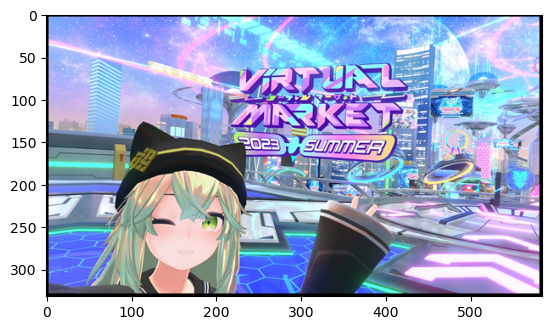

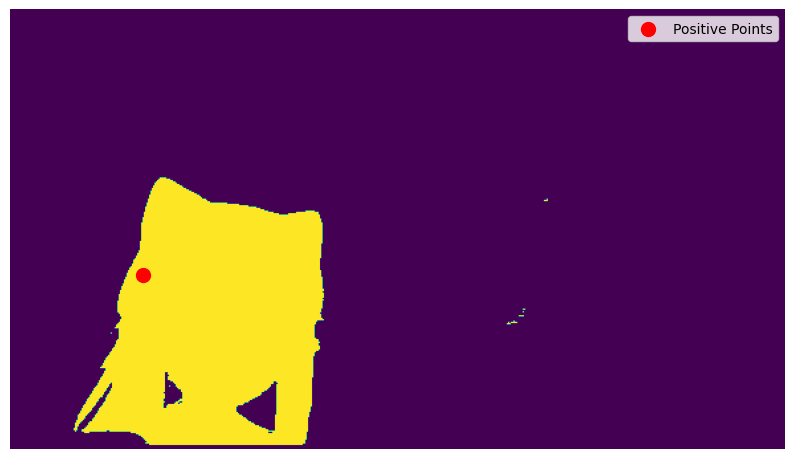

In [ ]:
import torch
from PIL import Image
from sam2_oringinal.sam2.sam2_image_predictor import SAM2ImagePredictor
import matplotlib.pyplot as plt
import numpy as np

# 打开图像并转换为 RGB
image_path = "/ndata/yzh/SAM2-for-XR/images/image.png"
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
# 加载模型
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

# 示例提示
# point_coords = [[100, 200], [150, 250]]  # 提供坐标点 (x, y)
# point_labels = [1, 0]  # 与坐标点对应的标签

point_coords = [[100, 200]]  # 提供坐标点 (x, y)
point_labels = [1]  # 与坐标点对应的标签
input_prompts = {
    "point_coords": point_coords,
    "point_labels": point_labels
}

# 设置图像并预测
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(image)
    masks, _, _ = predictor.predict(
        point_coords=input_prompts["point_coords"],
        point_labels=input_prompts["point_labels"]
    )

print("Prediction completed successfully.")

mask = masks[1]

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='jet')

# 提取坐标点
point_coords = np.array(point_coords)  # shape: (N, 2)
x_coords = point_coords[:, 0]
y_coords = point_coords[:, 1]

# 根据label区分点的类型
# 假设 label=1 为正例点（可用红色圆点表示）
#    label=0 为负例点（可用蓝色叉表示）
pos_points = point_coords[np.array(point_labels) == 1]
neg_points = point_coords[np.array(point_labels) == 0]

if len(pos_points) > 0:
    plt.scatter(pos_points[:, 0], pos_points[:, 1], c='red', marker='o', s=100, label='Positive Points')
if len(neg_points) > 0:
    plt.scatter(neg_points[:, 0], neg_points[:, 1], c='blue', marker='x', s=100, label='Negative Points')

plt.axis('off')
plt.legend()
plt.show()


## For video prediction:

In [6]:
%pip install --upgrade huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
from sam2.sam2_video_predictor import SAM2VideoPredictor

predictor = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-large")

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    state = predictor.init_state(<your_video>)

    # add new prompts and instantly get the output on the same frame
    frame_idx, object_ids, masks = predictor.add_new_points_or_box(state, <your_prompts>):

    # propagate the prompts to get masklets throughout the video
    for frame_idx, object_ids, masks in predictor.propagate_in_video(state):